In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import tensorflow as tf

%matplotlib inline
plt.style.use('ggplot')

In [2]:
def read_data(file_path):
    column_names = ['user-id','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
    data = pd.read_csv(file_path,header = None, names = column_names)
    return data

def feature_normalize(dataset):
    mu = np.mean(dataset,axis = 0)
    sigma = np.std(dataset,axis = 0)
    return (dataset - mu)/sigma
    
def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
def plot_activity(activity,data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (15, 10), sharex = True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()
    
def windows(data, size):
    start = 0
    while start < data.count():
        yield start, start + size
        start += (size / 2)

def segment_signal(data,window_size = 90):
    segments = np.empty((0,window_size,3))
    labels = np.empty((0))
    print len(data['timestamp'])
    #count = 0
    for (start, end) in windows(data['timestamp'], window_size):
        #print count
        #count += 1
        x = data["x-axis"][start:end]
        y = data["y-axis"][start:end]
        z = data["z-axis"][start:end]
        if(len(dataset['timestamp'][start:end]) == window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            labels = np.append(labels,stats.mode(data["activity"][start:end])[0][0])
    return segments, labels

# init nn parameters
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.0, shape = shape)
    return tf.Variable(initial)

# conv
def depthwise_conv2d(x, W):
    return tf.nn.depthwise_conv2d(x,W, [1, 1, 1, 1], padding='VALID')

def apply_depthwise_conv(x,kernel_size,num_channels,depth):
    weights = weight_variable([1, kernel_size, num_channels, depth])
    biases = bias_variable([depth * num_channels])
    return tf.nn.relu(tf.add(depthwise_conv2d(x, weights),biases))
    
def apply_max_pool(x,kernel_size,stride_size):
    return tf.nn.max_pool(x, ksize=[1, 1, kernel_size, 1], 
                          strides=[1, 1, stride_size, 1], padding='VALID')

# data distribution

   user-id activity      timestamp    x-axis    y-axis    z-axis
0     1679  Walking  1370520469556  0.294132 -0.635605 -0.226936
1     1679  Walking  1370520469606 -0.499688 -0.604451 -0.226020
2     1679  Walking  1370520469656 -2.178345  0.713491  0.372017
3     1679  Walking  1370520469706 -2.797763  1.354899 -0.277638
4     1679  Walking  1370520469756 -2.167961 -1.327716 -0.554971
5     1679  Walking  1370520469806 -1.734857  0.818559 -0.165544
6     1679  Walking  1370520469856 -1.463939  0.835969  0.411112
7     1679  Walking  1370520469906 -0.945008  1.085202  0.395230
8     1679  Walking  1370520469956  0.182038  0.281303  0.534202
9     1679  Walking  1370520470006  0.948368  0.078496  0.564745
Empty DataFrame
Columns: [Count]
Index: []
Empty DataFrame
Columns: [Count]
Index: []
         activity                                           
activity  Jogging LyingDown Sitting  Stairs Standing Walking
user-id                                                     
599           Na

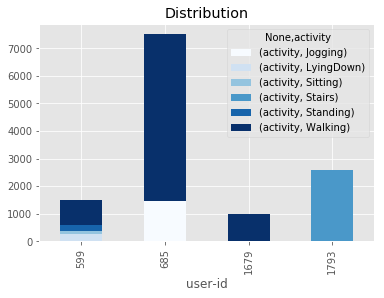

In [3]:
if __name__ == "__main__": 
    column_names = ['user-id', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis'] 
    df = pd.read_csv("dataset/actitracker_raw.txt", header=None, names=column_names) 
    n = 10 
    print df.head(n) 
    
    subject = pd.DataFrame(df["user-id"].value_counts(), columns=["Count"]) 
    subject.index.names = ['Subject'] 
    print subject.head(n) 
    
    activities = pd.DataFrame(df["activity"].value_counts(), columns=["Count"]) 
    activities.index.names = ['Activity'] 
    print activities.head(n) 
    
    activity_of_subjects = pd.DataFrame(df.groupby("user-id")["activity"].value_counts()) 
    print activity_of_subjects.unstack().head(n) 
    
    activity_of_subjects.unstack().plot(kind='bar', stacked=True, colormap='Blues', title="Distribution") 
    plt.show()

# data presentation

In [4]:
dataset = read_data('dataset/actitracker_raw.txt')
dataset['x-axis'] = feature_normalize(dataset['x-axis'])
dataset['y-axis'] = feature_normalize(dataset['y-axis'])
dataset['z-axis'] = feature_normalize(dataset['z-axis'])

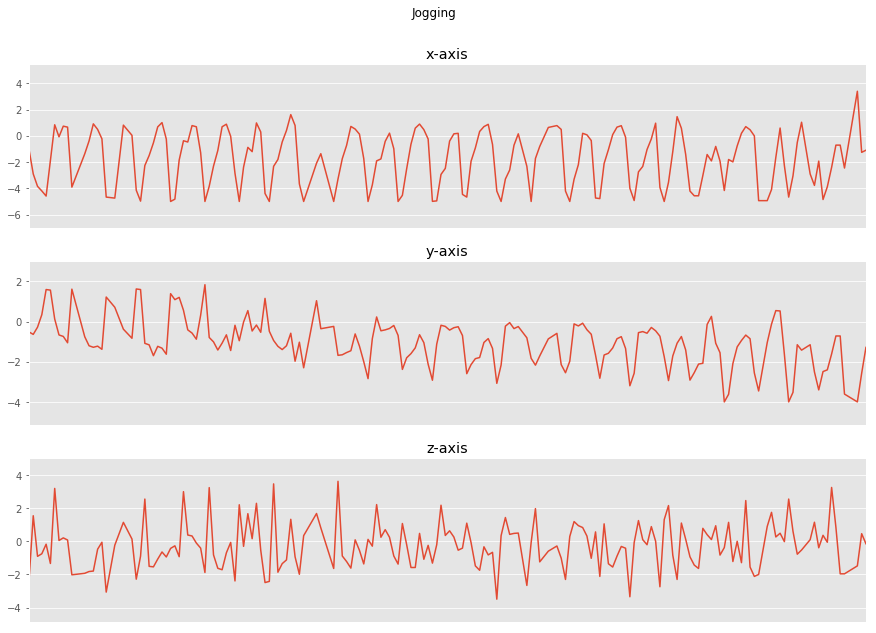

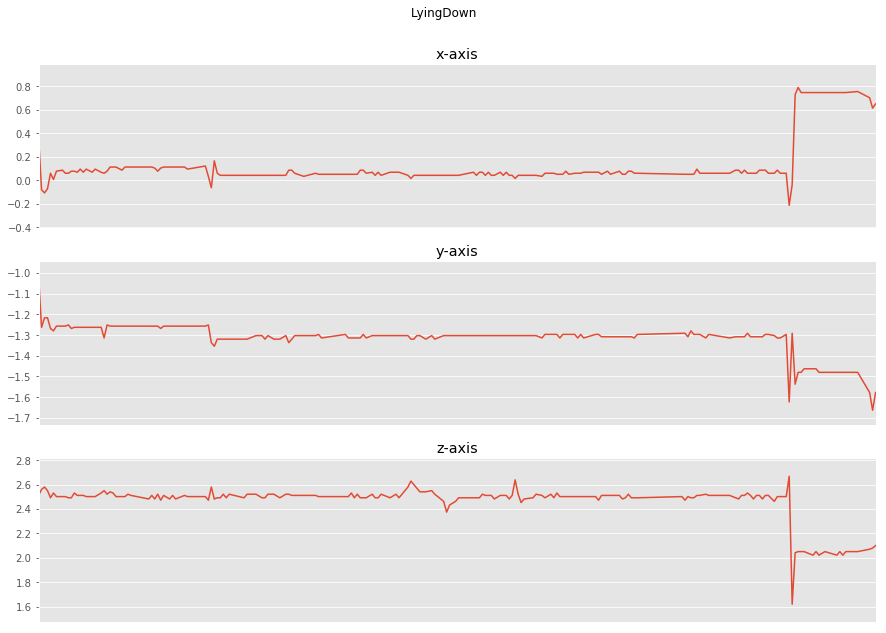

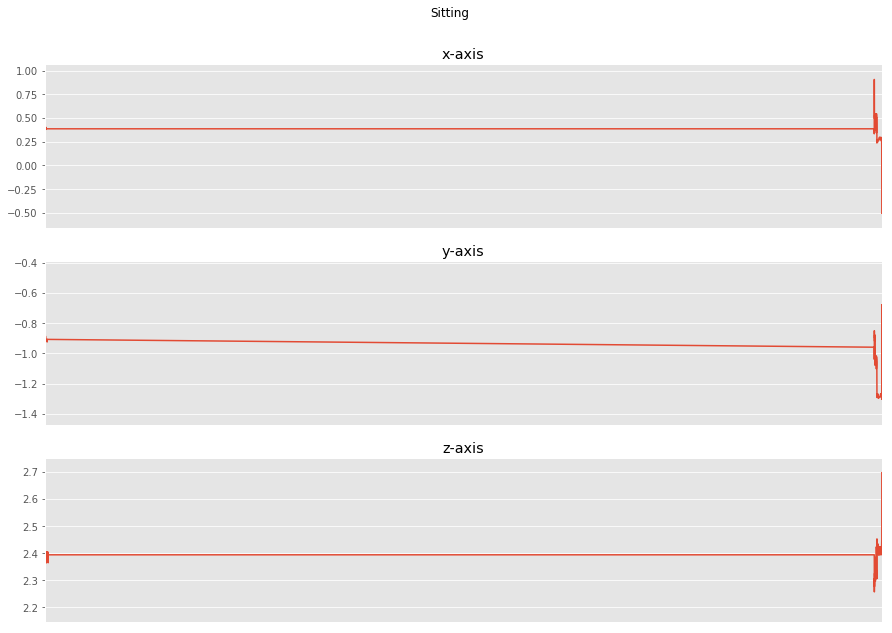

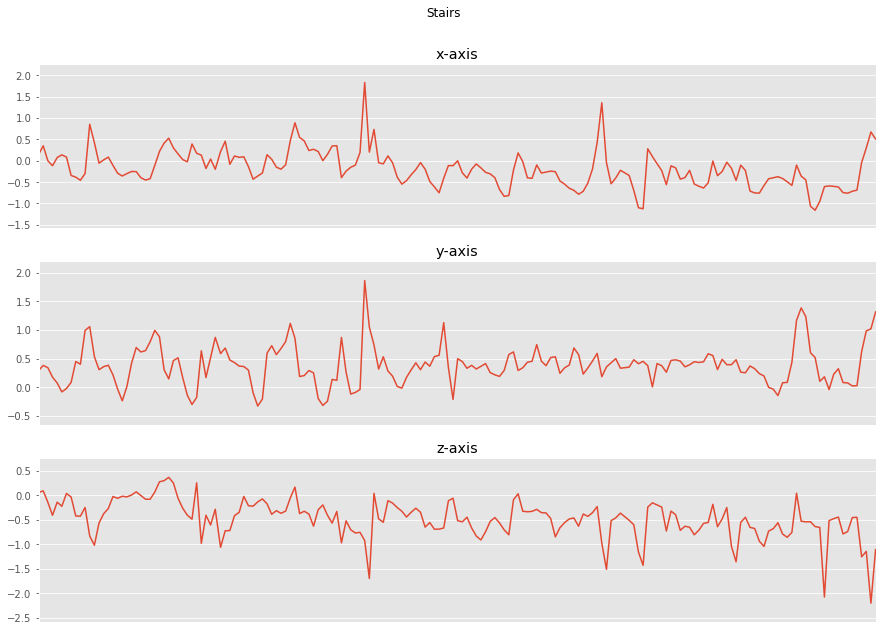

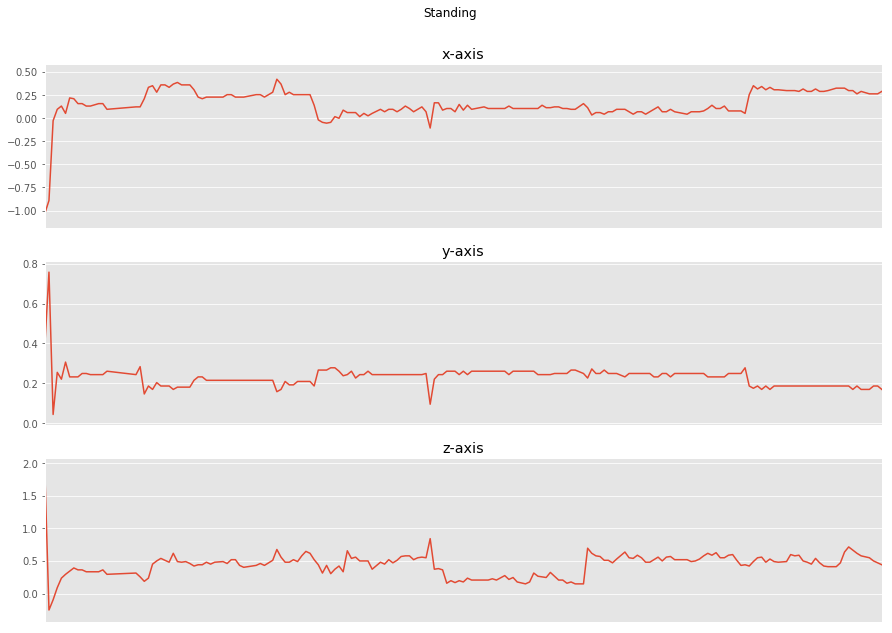

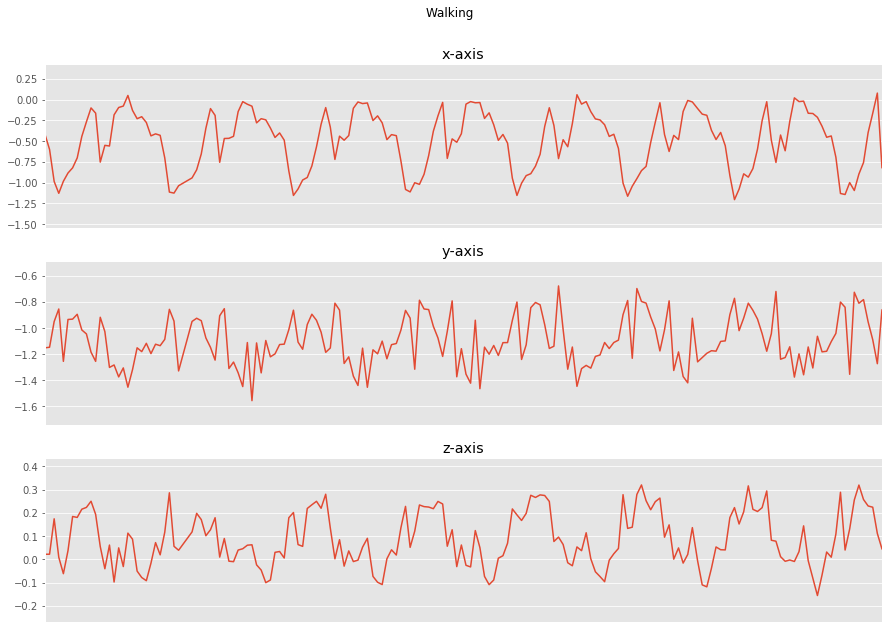

In [5]:
for activity in np.unique(dataset["activity"]):
    subset = dataset[dataset["activity"] == activity][:180]
    plot_activity(activity,subset)

# train and test model

In [6]:
segments, labels = segment_signal(dataset)
labels = np.asarray(pd.get_dummies(labels), dtype = np.int8)
reshaped_segments = segments.reshape(len(segments), 1,90, 3)
print len(segments)

12599


/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:253: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


278


### split data to train ans test

In [7]:
train_test_split = np.random.rand(len(reshaped_segments)) < 0.70
train_x = reshaped_segments[train_test_split]
train_y = labels[train_test_split]
test_x = reshaped_segments[~train_test_split]
test_y = labels[~train_test_split]

### define parameters

In [8]:
input_height = 1
input_width = 90
num_labels = 6
num_channels = 3

batch_size = 10
kernel_size = 60
depth = 60
num_hidden = 1000

learning_rate = 0.0001
# iteration times
training_epochs = 8

total_batches = train_x.shape[0] // batch_size

### build network

In [13]:
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)


In [14]:
loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

cost_history = np.empty(shape=[1], dtype=float)

### train network

In [15]:
with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        for b in range(total_batches):    
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print "Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ", \
          session.run(accuracy, feed_dict={X: train_x, Y: train_y})
    y_pred = tf.argmax(y_, 1)
    y_true = np.argmax(test_y, 1)
    final_acc, y_pred = session.run([accuracy, y_pred], feed_dict={X: test_x, Y: test_y})
    print "Testing Accuracy: {}".format(final_acc)
    print '\n'
    
    # model metrics
    temp_y_true = np.unique(y_true)
    temp_y_pred = np.unique(y_pred) 
    np.save("dataset/y_true", y_true) 
    np.save("dataset/y_pred", y_pred) 
    print "temp_y_true", temp_y_true 
    print "temp_y_pred", temp_y_pred
    
    print "Precision", precision_score(y_true.tolist(), y_pred.tolist(), average='weighted') 
    print "Recall", recall_score(y_true, y_pred, average='weighted') 
    print "f1_score", f1_score(y_true, y_pred, average='weighted') 
    print '\n'
    print "confusion_matrix: " 
    print confusion_matrix(y_true, y_pred)

Epoch:  0  Training Loss:  17.8846  Training Accuracy:  0.605128
Epoch:  1  Training Loss:  15.6272  Training Accuracy:  0.651282
Epoch:  2  Training Loss:  13.6267  Training Accuracy:  0.723077
Epoch:  3  Training Loss:  12.0031  Training Accuracy:  0.764103
Epoch:  4  Training Loss:  10.6932  Training Accuracy:  0.805128
Epoch:  5  Training Loss:  9.62006  Training Accuracy:  0.815385
Epoch:  6  Training Loss:  8.72931  Training Accuracy:  0.841026
Epoch:  7  Training Loss:  7.97826  Training Accuracy:  0.841026
Testing Accuracy: 0.879518032074


temp_y_true [0 1 2 3 4 5]
temp_y_pred [0 3 5]
Precision 0.845499645641
Recall 0.879518072289
f1_score 0.860240963855


confusion_matrix: 
[[12  0  0  0  0  1]
 [ 0  0  0  0  0  1]
 [ 0  0  0  0  0  2]
 [ 0  0  0 13  0  0]
 [ 0  0  0  0  0  1]
 [ 5  0  0  0  0 48]]


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# confusion matrix plot

Precision 0.845499645641
Recall 0.879518072289
f1_score 0.860240963855


confusion_matrix
[[12  0  0  0  0  1]
 [ 0  0  0  0  0  1]
 [ 0  0  0  0  0  2]
 [ 0  0  0 13  0  0]
 [ 0  0  0  0  0  1]
 [ 5  0  0  0  0 48]]


confusion_matrix: 
[[ 0.92307692  0.          0.          0.          0.          0.01886792]
 [ 0.          0.          0.          0.          0.          0.01886792]
 [ 0.          0.          0.          0.          0.          0.03773585]
 [ 0.          0.          0.          1.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.01886792]
 [ 0.38461538  0.          0.          0.          0.          0.90566038]]


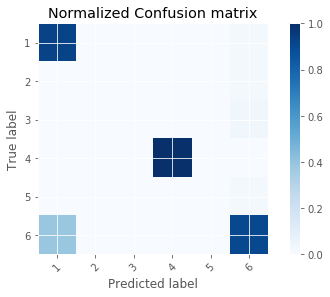

In [16]:
def plot_confusion_matrix(cm, title='Normalized Confusion matrix', cmap=plt.cm.get_cmap("Blues")): 
    cm = cm / cm.astype(np.float).sum(axis=1) 
    print "confusion_matrix: \n{}".format(cm) 
    plt.imshow(cm, interpolation='nearest', cmap=cmap) 
    plt.title(title) 
    plt.colorbar() 
    tick_marks = np.arange(6) 
    plt.xticks(tick_marks, [1, 2, 3, 4, 5, 6], rotation=45) 
    plt.yticks(tick_marks, [1, 2, 3, 4, 5, 6]) 
    plt.tight_layout() 
    plt.ylabel('True label') 
    plt.xlabel('Predicted label') 
    plt.show()

def test_har(): 
    y_true = np.load("dataset/y_true.npy") 
    y_pred = np.load("dataset/y_pred.npy") 
    print "Precision", precision_score(y_true.tolist(), y_pred.tolist(), average='weighted') 
    print "Recall", recall_score(y_true, y_pred, average='weighted') 
    print "f1_score", f1_score(y_true, y_pred, average='weighted')
    print '\n'
    print "confusion_matrix" 
    print confusion_matrix(y_true, y_pred) 
    print '\n'
    plot_confusion_matrix(confusion_matrix(y_true, y_pred))

if __name__ == "__main__":
    test_har()